In [1]:
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

#df = pd.read_csv('C:\\Users\\Ben\\OneDrive\\Documents\\Maryland_Statewide_Vehicle_Crashes_AA_Only.csv')
df = pd.read_csv('C:\\Users\\Ben\\OneDrive\\Documents\\Maryland_Statewide_Vehicle_Crashes.csv')

threshold = 0.5  # Set the threshold for missing values (e.g., 50%)
missing_percentage = df.isnull().mean()  # Calculate the percentage of missing values in each column
columns_to_drop = missing_percentage[missing_percentage > threshold].index  # Get the columns exceeding the threshold

df_dropped = df.drop(columns=columns_to_drop)  # Drop the columns from the DataFrame

C:\Users\Ben\AppData\Local\Temp\ipykernel_32696\917003478.py:7: DtypeWarning: Columns (33,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\Ben\\OneDrive\\Documents\\Maryland_Statewide_Vehicle_Crashes.csv')


In [5]:
from dash import dcc, html
import pandas as pd
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Assuming you have a DataFrame 'df' with 'ACC_TIME' and 'ACC_DATE' column

# Convert the ACC_TIME column to datetime format and extract the minute component
df['ACC_TIME'] = pd.to_datetime(df['ACC_TIME'])
df['MINUTE'] = df['ACC_TIME'].apply(lambda x: x.minute if pd.notnull(x) else None)

# Convert the ACC_DATE column to datetime format
df['ACC_DATE'] = pd.to_datetime(df['ACC_DATE'])

# Replace blank values in REPORT_TYPE column with 'Unknown'
df['REPORT_TYPE'] = df['REPORT_TYPE'].fillna('Unknown')

# Create the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='report_type_dropdown',
        options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].unique()],
        value='Unknown'
    ),
    dcc.Graph(id='map_graph'),
    dcc.Graph(id='histogram_graph')
])

@app.callback(
    [Output('map_graph', 'figure'), Output('histogram_graph', 'figure')],
    [Input('report_type_dropdown', 'value')]
)
def update_graphs(selected_report_type):
    df_filtered = df[df['REPORT_TYPE'] == selected_report_type]

    # Create the scatter map
    fig_map = px.scatter_mapbox(
        df_filtered,
        lat='LATITUDE',
        lon='LONGITUDE',
        color='REPORT_TYPE',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title='Crash locations in Maryla',
        opacity=0.25,
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    fig_map.update_layout(
        mapbox_style="mapbox://styles/mapbox/light-v10",
        mapbox_accesstoken='pk.eyJ1IjoiYmVuZ2JhbGxhcmQiLCJhIjoiY2xrMWp6dXFmMDZzZDNocGJ3Zjh5amMwZiJ9.YGDUZddiJp0uKNBG68Dhlw'
    )

    # Create the histogram
    fig_hist = px.histogram(
        df_filtered,
        x='MINUTE',
        color='REPORT_TYPE',
        facet_col='REPORT_TYPE',
        facet_col_wrap=2,
        nbins=24*4,
        title='Histogram of Crash Times',
        histnorm='probability density',
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    return fig_map, fig_hist

# Run the app
if __name__ == '__main__':
    app.run_server(mode='external', port=8050, dev_tools_ui=False, dev_tools_props_check=False)


In [7]:
import pandas as pd
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Assuming you have a DataFrame 'df' with 'ACC_TIME' column

# Convert the ACC_TIME column to datetime format and extract the minute component
df['MINUTE'] = df['ACC_TIME'].apply(lambda x: x.minute if pd.notnull(x) else None)

# Replace blank values in REPORT_TYPE column with 'Unknown'
df['REPORT_TYPE'] = df['REPORT_TYPE'].fillna('Unknown')

# Create the Dash app
app = Dash(__name__)

# Convert the ACC_Date to datetime format
df['ACC_Date'] = pd.to_datetime(df['ACC_DATE'], format='%Y%m%d')

# Define the app layout
app.layout = html.Div([
    dcc.Graph(id='scatter_mapbox', style={'height': '100vh'}),
    dcc.RangeSlider(
        id='date_slider',
        min=df['ACC_Date'].min().timestamp(),
        max=df['ACC_Date'].max().timestamp(),
        value=[df['ACC_Date'].min().timestamp(), df['ACC_Date'].max().timestamp()],
        marks={date.timestamp(): str(date.date()) for date in pd.date_range(start=df['ACC_Date'].min(), end=df['ACC_Date'].max(), freq='M')},
        step=None
    ),
    dcc.Graph(id='histogram', style={'height': '70vh'})
])

# Define the callback to update the scatter mapbox and histogram plots
@app.callback(
    [Output('scatter_mapbox', 'figure'), Output('histogram', 'figure')],
    [Input('date_slider', 'value')]
)
def update_plots(date_range):
    # Filter the data based on the date range
    df_filtered = df[(df['ACC_Date'] >= pd.to_datetime(date_range[0], unit='s')) & (df['ACC_Date'] <= pd.to_datetime(date_range[1], unit='s'))]
    
    # Create the scatter mapbox plot
    fig_map = px.scatter_mapbox(
        df_filtered,
        lat='LATITUDE',
        lon='LONGITUDE',
        color='REPORT_TYPE',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title='Crash locations in Anne Arundel County',
        opacity=0.4,
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    fig_map.update_layout(
        mapbox_style="mapbox://styles/mapbox/light-v10",
        mapbox_accesstoken='pk.eyJ1IjoiYmVuZ2JhbGxhcmQiLCJhIjoiY2xrMWp6dXFmMDZzZDNocGJ3Zjh5amMwZiJ9.YGDUZddiJp0uKNBG68Dhlw'
    )
    
    # Create the histogram
    fig_hist = px.histogram(
        df_filtered,
        x='MINUTE',
        color='REPORT_TYPE',
        facet_col='REPORT_TYPE',
        facet_col_wrap=2,
        nbins=24*4,
        title='Histogram of Crash Times',
        histnorm='probability density',
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    return fig_map, fig_hist

# Run the app and save it as an HTML file
if __name__ == '__main__':
    app.run_server(mode='external', port=8050, dev_tools_ui=False, dev_tools_props_check=False)


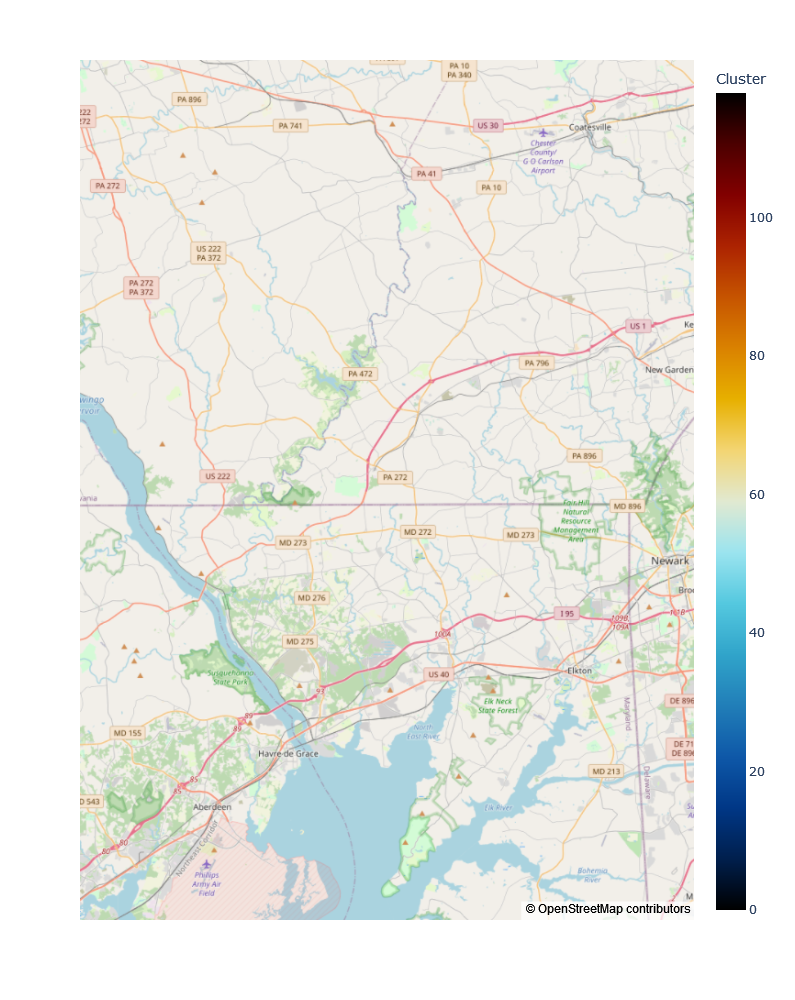

In [8]:
import pandas as pd
from sklearn.cluster import DBSCAN
import plotly.express as px

# Assuming you have a DataFrame 'df' with 'LATITUDE' and 'LONGITUDE' columns

sample_size = 20000  # Define the desired sample size
sampled_data = df.sample(n=sample_size, random_state=1)  # Sample the data

X = sampled_data[['LATITUDE', 'LONGITUDE']]  # Select latitude and longitude columns

# Perform DBSCAN clustering
eps = 0.001  # epsilon: maximum distance between two points to be considered in the same neighborhood
min_samples = 20  # minimum number of points in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Add the cluster labels to the sampled DataFrame
sampled_data['Cluster'] = labels

# Filter out unclustered points
filtered_data = sampled_data[sampled_data['Cluster'] != -1]

# Visualize the clusters on a map
fig = px.scatter_mapbox(filtered_data, lat='LATITUDE', lon='LONGITUDE', color='Cluster',
                        hover_data=['LATITUDE', 'LONGITUDE'], color_continuous_scale=px.colors.cyclical.IceFire, zoom=10)

fig.update_layout(mapbox_style='open-street-map', height=1000, width=2000)

fig.show()


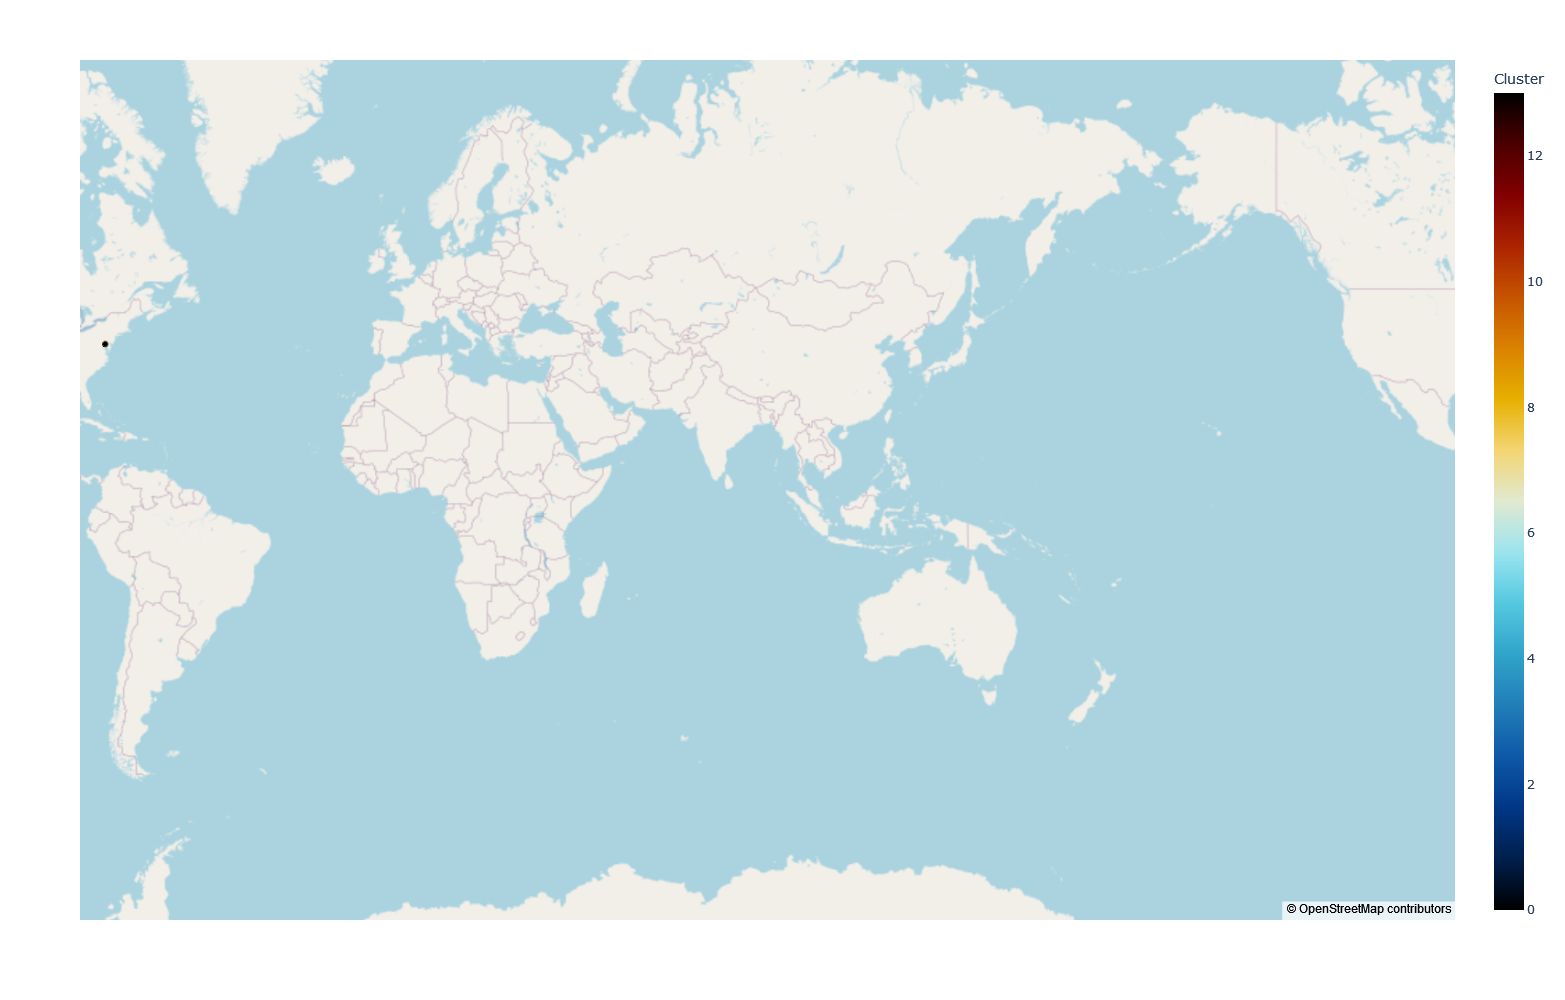

In [62]:
import pandas as pd
from sklearn.cluster import DBSCAN
import plotly.express as px

# Assuming you have a DataFrame 'df' with 'LATITUDE' and 'LONGITUDE' columns

# Filter the data by REPORT_TYPE == "Fatal Crash"
filtered_data = df[df['REPORT_TYPE'] == "Fatal Crash"]

sample_size = min(len(filtered_data), 20000)  # Define the desired sample size, limited by the available data
sampled_data = filtered_data.sample(n=sample_size, random_state=1)  # Sample the filtered data

X = sampled_data[['LATITUDE', 'LONGITUDE']]  # Select latitude and longitude columns

# Perform DBSCAN clustering
eps = 0.01  # epsilon: maximum distance between two points to be considered in the same neighborhood
min_samples = 5  # minimum number of points in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Add the cluster labels to the sampled DataFrame
sampled_data['Cluster'] = labels

# Filter out unclustered points
filtered_data = sampled_data[sampled_data['Cluster'] != -1]

# Visualize the clusters on a map
fig = px.scatter_mapbox(filtered_data, lat='LATITUDE', lon='LONGITUDE', color='Cluster',
                        hover_data=['LATITUDE', 'LONGITUDE'], color_continuous_scale=px.colors.cyclical.IceFire, zoom=10)

fig.update_layout(mapbox_style='open-street-map', height=1000, width=2000)

fig.show()

In [42]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output

# Import the data
df = pd.read_csv('DF_output.csv')

# Convert ACC_DATE to datetime format
df['ACC_DATE'] = pd.to_datetime(df['ACC_DATE'], format='%Y%m%d')

# Combine ACC_DATE and ACC_TIME into a single datetime column
df['ACC_DATETIME'] = pd.to_datetime(df['ACC_DATE'].astype(str) + ' ' + df['ACC_TIME'])

# Extract hour and month from ACC_DATETIME
df['HOUR'] = df['ACC_DATETIME'].dt.hour
df['MONTH'] = df['ACC_DATETIME'].dt.month

# Pre-compute the data for the plots
hourly_counts = df.groupby(['HOUR', 'COUNTY_DESC', 'REPORT_TYPE']).size().reset_index()
hourly_counts.columns = ['HOUR', 'COUNTY_DESC', 'REPORT_TYPE', 'COUNT']
county_counts = df.groupby(['COUNTY_DESC', 'REPORT_TYPE']).size().unstack(fill_value=0).reset_index()

# Create the Dash app
app = dash.Dash(__name__)
server = app.server

# Define the app layout
app.layout = html.Div([
    html.H1("Maryland Car Crash Analysis"),
    
    html.Div([
        dcc.Dropdown(
            id='hourly-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
            style={"width": "50%"}
        ),
        dcc.Graph(id='hourly-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='county-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
            style={"width": "50%"}
        ),
        dcc.Graph(id='county-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='map-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
        style={'width': '50%'}
        ),
        dcc.Graph(id='map-graph')
    ])
])


# Define the app callbacks

#Hourly Crash
@app.callback(
    Output('hourly-graph', 'figure'),
    Input('hourly-dropdown', 'value'))
def update_hourly_graph(crash_type):
    filtered_df = hourly_counts[hourly_counts['REPORT_TYPE'] == crash_type]
    fig = px.line(filtered_df, x='HOUR', y='COUNT', color='COUNTY_DESC', title='Hourly Trend in Crashes')
    return fig

#County Crash
@app.callback(
    Output('county-graph', 'figure'),
    Input('county-dropdown', 'value'))
def update_county_graph(crash_type):
    if crash_type in county_counts.columns:  # Check if the selected crash type is a column in the DataFrame
        fig = px.bar(county_counts, x='COUNTY_DESC', y=crash_type, title='Crashes by County')
    else:  # If not, create an empty figure
        fig = px.bar(title='No data available for the selected crash type')
    return fig

#Map Crash
@app.callback(
    Output('map-graph', 'figure'),
    Input('map-dropdown', 'value'))
def update_map_graph(crash_type):
    df_filtered = df[df['REPORT_TYPE'] == crash_type]
    fig_map = px.scatter_mapbox(
        df_filtered,
        lat='LATITUDE',
        lon='LONGITUDE',
        width=1000,
        height=800,
        color='REPORT_TYPE',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title='Crash locations in Maryland',
        opacity=0.25,
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    fig_map.update_layout(
        mapbox_style="mapbox://styles/mapbox/light-v10",
        mapbox_accesstoken='pk.eyJ1IjoiYmVuZ2JhbGxhcmQiLCJhIjoiY2xrMWp6dXFmMDZzZDNocGJ3Zjh5amMwZiJ9.YGDUZddiJp0uKNBG68Dhlw'
    )
    return fig_map

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


In [2]:
# Import the data
df = pd.read_csv('DF_output.csv')

# Convert ACC_DATE to datetime format
df['ACC_DATE'] = pd.to_datetime(df['ACC_DATE'], format='%Y%m%d')

# Combine ACC_DATE and ACC_TIME into a single datetime column
df['ACC_DATETIME'] = pd.to_datetime(df['ACC_DATE'].astype(str) + ' ' + df['ACC_TIME'])

# Extract hour and month from ACC_DATETIME
df['HOUR'] = df['ACC_DATETIME'].dt.hour
df['MONTH'] = df['ACC_DATETIME'].dt.month

In [62]:
df.head()

YEAR      LIGHT_DESC COUNTY_DESC            REPORT_TYPE WEATHER_DESC  \
0  2022  Dark Lights On  Montgomery  Property Damage Crash          NaN   
1  2022        Daylight   Baltimore  Property Damage Crash          NaN   
2  2022        Daylight   Baltimore  Property Damage Crash          NaN   
3  2022             NaN   Baltimore  Property Damage Crash          NaN   
4  2022        Daylight      Howard           Injury Crash          NaN   

    ACC_DATE  ACC_TIME   LATITUDE  LONGITUDE        ACC_DATETIME  HOUR  MONTH  
0 2022-04-22  22:49:00  38.992210 -77.097021 2022-04-22 22:49:00    22      4  
1 2022-02-26  12:00:00  39.411213 -76.628028 2022-02-26 12:00:00    12      2  
2 2022-12-12  15:45:00  39.377559 -76.724014 2022-12-12 15:45:00    15     12  
3 2022-04-11  18:57:00  39.463704 -76.608660 2022-04-11 18:57:00    18      4  
4 2022-12-09  15:57:00  39.251350 -76.817769 2022-12-09 15:57:00    15     12

In [17]:
# Import required libraries
import plotly.express as px
import pandas as pd
import time

start_time = time.time()
# Create a new DataFrame with daily accident counts for each county
daily_counts = df.groupby(['ACC_DATE', 'COUNTY_DESC']).size().reset_index()
daily_counts.columns = ['ACC_DATE', 'COUNTY_DESC', 'COUNT']
print(f'Time taken to import data: {time.time() - start_time} seconds')

Time taken to import data: 0.08497238159179688 seconds


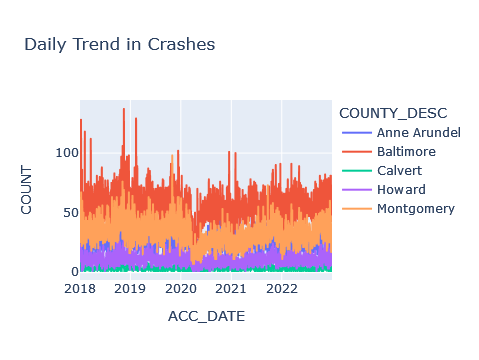

In [18]:
# Create the line plot
fig = px.line(daily_counts, x='ACC_DATE', y='COUNT', color='COUNTY_DESC', title='Daily Trend in Crashes')

# Show the plot
fig.show()

C:\Users\Ben\AppData\Local\Temp\ipykernel_57184\1384644358.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Ben\AppData\Local\Temp\ipykernel_57184\1384644358.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Ben\AppData\Local\Temp\ipykernel_57184\1384644358.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Ben\AppData\Local\Temp\ipykernel_57184\1384644358.py:11: FutureWarning:

The de

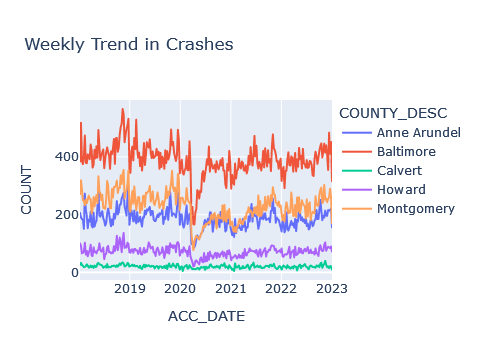

In [10]:
# Reset the index (if it's already set)
daily_counts.reset_index(inplace=True)

# Ensure ACC_DATE is in datetime format
daily_counts['ACC_DATE'] = pd.to_datetime(daily_counts['ACC_DATE'])

# Set ACC_DATE as the DataFrame index
daily_counts.set_index('ACC_DATE', inplace=True)

# Create a new DataFrame with weekly accident counts for each county
weekly_counts = daily_counts.groupby('COUNTY_DESC').resample('W').sum().reset_index()

# Plot the data
fig = px.line(weekly_counts, x='ACC_DATE', y='COUNT', color='COUNTY_DESC', title='Weekly Trend in Crashes')
fig.show()


In [60]:
df.head()

YEAR      LIGHT_DESC COUNTY_DESC            REPORT_TYPE  \
ACC_DATE                                                              
2022-04-22  2022  Dark Lights On  Montgomery  Property Damage Crash   
2022-02-26  2022        Daylight   Baltimore  Property Damage Crash   
2022-12-12  2022        Daylight   Baltimore  Property Damage Crash   
2022-04-11  2022             NaN   Baltimore  Property Damage Crash   
2022-12-09  2022        Daylight      Howard           Injury Crash   

           WEATHER_DESC  ACC_TIME   LATITUDE  LONGITUDE        ACC_DATETIME  \
ACC_DATE                                                                      
2022-04-22          NaN  22:49:00  38.992210 -77.097021 2022-04-22 22:49:00   
2022-02-26          NaN  12:00:00  39.411213 -76.628028 2022-02-26 12:00:00   
2022-12-12          NaN  15:45:00  39.377559 -76.724014 2022-12-12 15:45:00   
2022-04-11          NaN  18:57:00  39.463704 -76.608660 2022-04-11 18:57:00   
2022-12-09          NaN  15:57:00  39.251350 -76.817769 2022-12-09 15:57:00   

            HOUR  MONTH  
ACC_DATE                 
2022-04-22    22      4  
2022-02-26    12      2  
2022-12-12    15     12  
2022-04-11    18      4  
2022-12-09    15     12

In [88]:
# Convert ACC_DATE from index to a column
daily_counts.reset_index(inplace=True)
# Create a 'day_of_year' column
daily_counts['day_of_year'] = daily_counts['ACC_DATE'].dt.dayofyear
# Split the data into pre-COVID and post-COVID periods
pre_covid = daily_counts[daily_counts['ACC_DATE'] < '2020-03-1']
post_covid = daily_counts[daily_counts['ACC_DATE'] >= '2020-03-1']
# Calculate the average daily crash rate for each day of the year in the pre-COVID period
pre_covid_avg = pre_covid.groupby('day_of_year')['COUNT'].mean()
# Merge pre-covid average to post-covid DataFrame
post_covid = post_covid.merge(pre_covid_avg, on='day_of_year', how='left', suffixes=('_post', '_pre'))
# Calculate the crash rates as a percentage of the pre-covid baseline
post_covid['percentage_of_pre_covid'] = (post_covid['COUNT_post'] / post_covid['COUNT_pre']) * 100

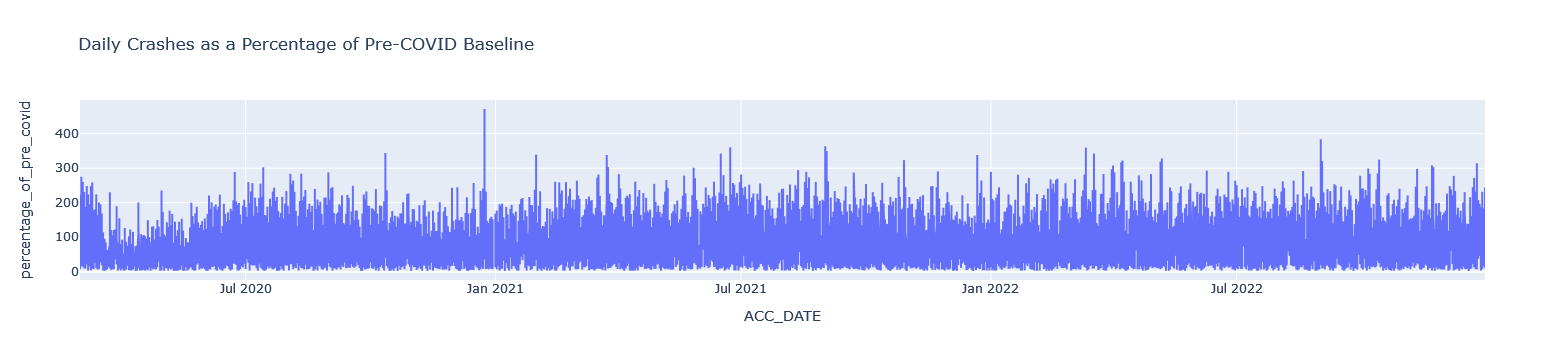

In [88]:
# Plot the crash rates over time
fig = px.line(post_covid, x='ACC_DATE', y='percentage_of_pre_covid', 
               title='Daily Crashes as a Percentage of Pre-COVID Baseline')
fig.show()

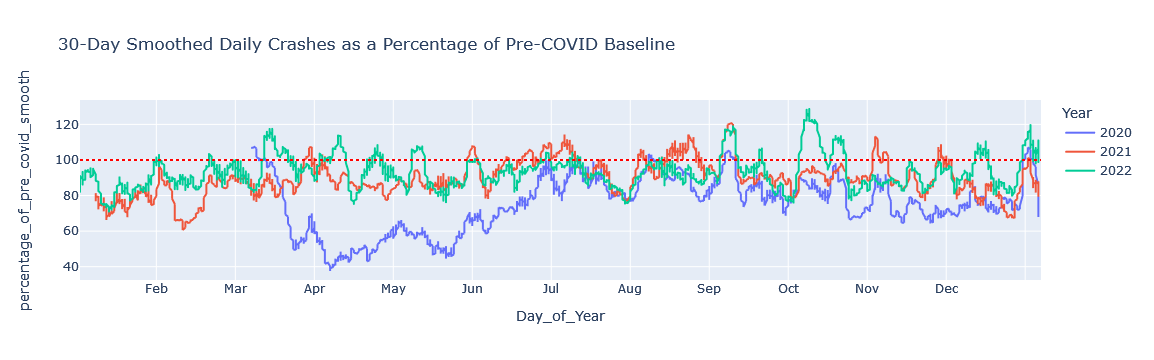

In [102]:
# Extract the day of the year and year as separate columns
post_covid['Day_of_Year'] = post_covid['ACC_DATE'].dt.dayofyear
post_covid['Year'] = post_covid['ACC_DATE'].dt.year

# Apply a 7-day rolling average to the percentage data
post_covid['percentage_of_pre_covid_smooth'] = post_covid['percentage_of_pre_covid'].rolling(window=30).mean()

# Plot the smoothed crash rates over time, with different colors for each year
fig = px.line(post_covid, x='Day_of_Year', y='percentage_of_pre_covid_smooth', color='Year',
              title='30-Day Smoothed Daily Crashes as a Percentage of Pre-COVID Baseline')

# Add horizontal line at y=100
fig.add_shape(type='line',
              xref='paper', yref='y',
              x0=0, x1=1, y0=100, y1=100,
              line=dict(color='Red', dash='dot'))

# Update x-axis to show each month. Note that the x-axis is now in days of the year.
months_in_year = [i*30 for i in range(13)]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
fig.update_xaxes(
    tickvals=months_in_year,
    ticktext=month_names)

fig.show()


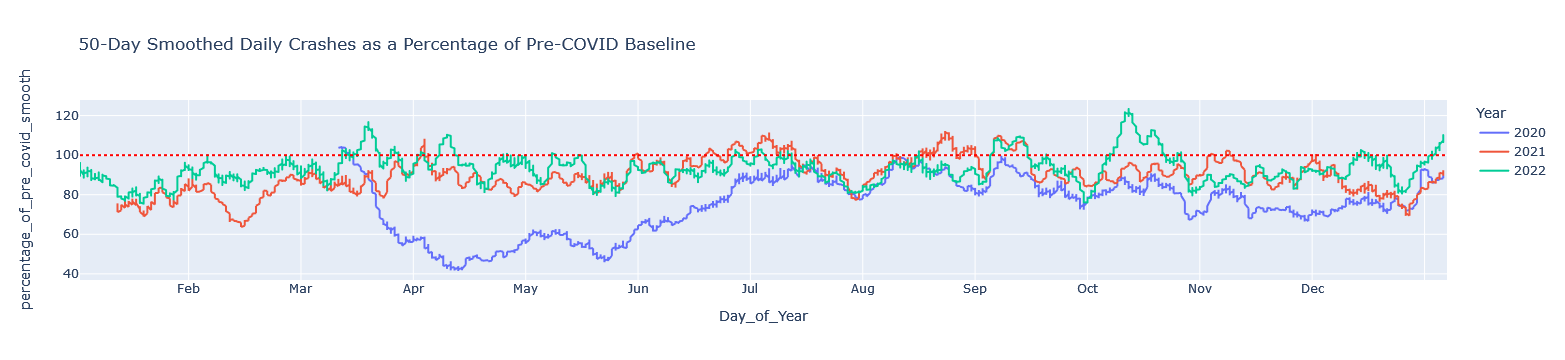

In [103]:
# Import necessary libraries
import matplotlib.dates as mdates

# Extract the day of the year and year as separate columns
post_covid['Day_of_Year'] = post_covid['ACC_DATE'].dt.dayofyear
post_covid['Year'] = post_covid['ACC_DATE'].dt.year

# Apply a 7-day rolling average to the percentage data
post_covid['percentage_of_pre_covid_smooth'] = post_covid['percentage_of_pre_covid'].rolling(window=50).mean()

# Plot the smoothed crash rates over time, with different colors for each year
fig = px.line(post_covid, x='Day_of_Year', y='percentage_of_pre_covid_smooth', color='Year',
              title='50-Day Smoothed Daily Crashes as a Percentage of Pre-COVID Baseline')

# Add horizontal line at y=100
fig.add_shape(type='line',
              xref='paper', yref='y',
              x0=0, x1=1, y0=100, y1=100,
              line=dict(color='Red', dash='dot'))

# Update x-axis to show each month. Note that the x-axis is now in days of the year.
months_in_year = [i*30 for i in range(13)]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
fig.update_xaxes(
    tickvals=months_in_year,
    ticktext=month_names)

fig.show()


In [48]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output

# Import the data
df = pd.read_csv('DF_Output_Processed.csv')

# Pre-compute the data for the plots
hourly_counts = df.groupby(['HOUR', 'COUNTY_DESC', 'REPORT_TYPE']).size().reset_index()
hourly_counts.columns = ['HOUR', 'COUNTY_DESC', 'REPORT_TYPE', 'COUNT']
county_counts = df.groupby(['COUNTY_DESC', 'REPORT_TYPE']).size().unstack(fill_value=0).reset_index()

#For Long Term Trends
daily_counts = df.groupby(['ACC_DATE', 'COUNTY_DESC']).size().reset_index()
daily_counts['ACC_DATE'] = pd.to_datetime(daily_counts['ACC_DATE'])
daily_counts.columns = ['ACC_DATE', 'COUNTY_DESC', 'COUNT']
daily_counts.reset_index(inplace=True)
daily_counts['day_of_year'] = daily_counts['ACC_DATE'].dt.dayofyear
pre_covid = daily_counts[daily_counts['ACC_DATE'] < '2020-03-1']
post_covid = daily_counts[daily_counts['ACC_DATE'] >= '2020-03-1']
pre_covid_avg = pre_covid.groupby('day_of_year')['COUNT'].mean()
post_covid = post_covid.merge(pre_covid_avg, on='day_of_year', how='left', suffixes=('_post', '_pre'))
post_covid['percentage_of_pre_covid'] = (post_covid['COUNT_post'] / post_covid['COUNT_pre']) * 100
post_covid['Day_of_Year'] = post_covid['ACC_DATE'].dt.dayofyear
post_covid['Year'] = post_covid['ACC_DATE'].dt.year
post_covid['percentage_of_pre_covid_smooth'] = post_covid['percentage_of_pre_covid'].rolling(window=30).mean()

# Create the Dash app
app = dash.Dash(__name__)
server = app.server

# Define the app layout
app.layout = html.Div([
    html.H1("Maryland Car Crash Analysis"),
    
    html.Div([
        dcc.Dropdown(
            id='hourly-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
            style={"width": "50%"}
        ),
        dcc.Graph(id='hourly-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='county-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
            style={"width": "50%"}
        ),
        dcc.Graph(id='county-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='map-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Property Damage Crash',
        style={'width': '50%'}
        ),
        dcc.Graph(id='map-graph')
    ]),
    html.Div([
        html.H2("COVID-19 Crash Analysis"),
        dcc.Graph(id='covid-graph')
    ])
    
])


## Define the app callbacks

#Hourly Crash
@app.callback(
    Output('hourly-graph', 'figure'),
    Input('hourly-dropdown', 'value'))
def update_hourly_graph(crash_type):
    filtered_df = hourly_counts[hourly_counts['REPORT_TYPE'] == crash_type]
    fig = px.line(filtered_df, x='HOUR', y='COUNT', color='COUNTY_DESC', title='Hourly Trend in Crashes')
    return fig

#County Crash
@app.callback(
    Output('county-graph', 'figure'),
    Input('county-dropdown', 'value'))
def update_county_graph(crash_type):
    if crash_type in county_counts.columns:  # Check if the selected crash type is a column in the DataFrame
        fig = px.bar(county_counts, x='COUNTY_DESC', y=crash_type, title='Crashes by County')
    else:  # If not, create an empty figure
        fig = px.bar(title='No data available for the selected crash type')
    return fig

#COVID Crash Analysis
@app.callback(
    Output('covid-graph', 'figure'),
    [Input('county-dropdown', 'value')])  # This input isn't used, but you can replace it as needed
def update_covid_graph(crash_type):  # This input isn't used, but you can replace it as needed
    # The graph creation steps go here
    fig = px.line(post_covid, x='Day_of_Year', y='percentage_of_pre_covid_smooth', color='Year',
                  title='30-Day Smoothed Daily Crashes as a Percentage of Pre-COVID Baseline')
    fig.add_shape(type='line', xref='paper', yref='y', x0=0, x1=1, y0=100, y1=100, line=dict(color='Red', dash='dot'))
    months_in_year = [i*30 for i in range(13)]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
    fig.update_xaxes(tickvals=months_in_year, ticktext=month_names)
    
    return fig


#Map Crash
@app.callback(
    Output('map-graph', 'figure'),
    Input('map-dropdown', 'value'))
def update_map_graph(crash_type):
    df_filtered = df[df['REPORT_TYPE'] == crash_type]
    fig_map = px.scatter_mapbox(
        df_filtered,
        lat='LATITUDE',
        lon='LONGITUDE',
        width=800,
        height=800,
        color='REPORT_TYPE',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title='Crash locations in Maryland',
        opacity=0.25,
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    fig_map.update_layout(
        mapbox_style="mapbox://styles/mapbox/light-v10",
        mapbox_accesstoken='pk.eyJ1IjoiYmVuZ2JhbGxhcmQiLCJhIjoiY2xrMWp6dXFmMDZzZDNocGJ3Zjh5amMwZiJ9.YGDUZddiJp0uKNBG68Dhlw'
    )
    return fig_map

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


In [26]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output

# Import the data
df = pd.read_csv('DF_Output_Processed.csv')

hourly_counts = pd.read_csv('assets/hourly_counts.csv')
post_covid = pd.read_csv('assets/post_covid.csv')
county_counts = pd.read_csv('assets/county_counts.csv')
monthly_counts = pd.read_csv('assets/monthly_counts.csv')
daily_counts = pd.read_csv('assets/daily_counts.csv')


# Create the Dash app
app = dash.Dash(__name__)
server = app.server

# Define the app layout
app.layout = html.Div([
    html.Div([
        html.H1("Annapolis Car Crash Analysis", style={'display': 'inline-block'}),
        html.Img(src=app.get_asset_url('maryland.png'), style={'position': 'absolute', 'right': '0', 'top': '0'})
    ]),

    html.Div([
        dcc.Dropdown(
            id='map-dropdown',
            options=[{'label': i, 'value': i} for i in df['REPORT_TYPE'].dropna().unique()],
            value='Fatal Crash',
        style={'width': '50%'}
        ),
        dcc.Graph(id='map-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='hourly-dropdown',
            options=[{'label': i, 'value': i} for i in df['COUNTY_DESC'].dropna().unique()],
            value='Anne Arundel',
            style={"width": "50%"}
        ),
        dcc.Graph(id='hourly-graph')
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='day-dropdown',
            options=[{'label': i, 'value': i} for i in df['COUNTY_DESC'].dropna().unique()],
            value='Anne Arundel',
            style={"width": "50%"}
        ),
        dcc.Graph(id='day-graph')
    ]),
        
    html.Div([
        dcc.Dropdown(
            id='monthly-dropdown',
            options=[{'label': i, 'value': i} for i in df['COUNTY_DESC'].dropna().unique()],
            value='Anne Arundel',
            style={"width": "50%"}
        ),
        dcc.Graph(id='monthly-graph')
    ]),
    
    html.Div([
        html.H2("COVID-19 Crash Analysis"),
        dcc.Graph(id='covid-graph')
    ])
    
])

#Hourly Crash
@app.callback(
    Output('hourly-graph', 'figure'),
    Input('hourly-dropdown', 'value'))
def update_hourly_graph(County):
    filtered_df = hourly_counts[hourly_counts['COUNTY_DESC'] == County]
    fig = px.line(filtered_df, x='HOUR', y='COUNT', color='REPORT_TYPE', title='Hourly Trend in Crashes')
    return fig

#Day Crash
@app.callback(
    Output('day-graph', 'figure'),
    Input('day-dropdown', 'value'))
def update_day_graph(County):
    filtered_df = daily_counts[daily_counts['COUNTY_DESC'] == County]
    fig = px.line(filtered_df, x='DAY', y='COUNT', color='REPORT_TYPE', title='Daily Trend in Crashes')
    return fig


## Define the app callbacks
@app.callback(
    Output('monthly-graph', 'figure'),
    Input('monthly-dropdown', 'value'))
def update_monthly_graph(County):
    filtered_df = monthly_counts[monthly_counts['COUNTY_DESC'] == County]
    fig = px.bar(filtered_df, x='MONTH', y='COUNT', color='REPORT_TYPE', title='Monthly Trend in Crashes')
    return fig

#COVID Crash Analysis
@app.callback(
    Output('covid-graph', 'figure'),
    [Input('map-dropdown', 'value')])
def update_covid_graph(dummy_input):
    fig = px.line(post_covid, x='Day_of_Year', y='percentage_of_pre_covid_smooth', color='Year',
                  title='30-Day Smoothed Daily Crashes as a Percentage of Pre-COVID Baseline')
    fig.add_shape(type='line', xref='paper', yref='y', x0=0, x1=1, y0=100, y1=100, line=dict(color='Red', dash='dot'))
    months_in_year = [i*30 for i in range(13)]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
    fig.update_xaxes(tickvals=months_in_year, ticktext=month_names)   
    return fig


#Map Crash
@app.callback(
    Output('map-graph', 'figure'),
    Input('map-dropdown', 'value'))
def update_map_graph(crash_type):
    df_filtered = df[df['REPORT_TYPE'] == crash_type]
    fig_map = px.scatter_mapbox(
        df_filtered,
        lat='LATITUDE',
        lon='LONGITUDE',
        width=1200,
        height=800,
        color='REPORT_TYPE',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title='Crash locations in Maryland',
        opacity=0.25,
        category_orders={'REPORT_TYPE': ['Fatal Crash', 'Injury Crash', 'Property Damage Crash', 'Unknown']}
    )

    fig_map.update_layout(
        mapbox_style="mapbox://styles/mapbox/light-v10",
        mapbox_accesstoken='pk.eyJ1IjoiYmVuZ2JhbGxhcmQiLCJhIjoiY2xrMWp6dXFmMDZzZDNocGJ3Zjh5amMwZiJ9.YGDUZddiJp0uKNBG68Dhlw'
    )
    return fig_map

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)
